In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "last"

pd.set_option('display.max_rows', 10000)

# EDA for EIA data

In [24]:
## Load in EIA data
eia_data = pd.read_feather('eia.feather')
eia_data['date_time'] = pd.to_datetime(eia_data['period'], format='%Y-%m-%dT%H')
eia_data['value'] = pd.to_numeric(eia_data['value'])
eia_data.info(show_counts=True)


<class 'pandas.core.frame.DataFrame'>
Index: 1757255 entries, 0 to 2254
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   period           1757255 non-null  object        
 1   respondent       1757255 non-null  object        
 2   respondent-name  1757255 non-null  object        
 3   fueltype         1757255 non-null  object        
 4   type-name        1757255 non-null  object        
 5   value            1757255 non-null  int64         
 6   value-units      1757255 non-null  object        
 7   date_time        1757255 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 120.7+ MB


In [64]:
eia_data.head()

,period,respondent,respondent-name,fueltype,type-name,value,value-units,date_time
0,2024-01-01T00,CAL,California,COL,Coal,263,megawatthours,2024-01-01
1,2024-01-01T00,CAL,California,NG,Natural Gas,12835,megawatthours,2024-01-01
2,2024-01-01T00,CAL,California,NUC,Nuclear,2232,megawatthours,2024-01-01
3,2024-01-01T00,CAL,California,OIL,Petroleum,46,megawatthours,2024-01-01
4,2024-01-01T00,CAL,California,OTH,Other,555,megawatthours,2024-01-01
5,2024-01-01T00,CAL,California,SUN,Solar,4527,megawatthours,2024-01-01
6,2024-01-01T00,CAL,California,WAT,Hydro,2246,megawatthours,2024-01-01
7,2024-01-01T00,CAL,California,WND,Wind,98,megawatthours,2024-01-01


/var/folders/s9/9q8cs9l92wd15gsnz7n8f0x40000gn/T/ipykernel_57140/3314862974.py:8: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



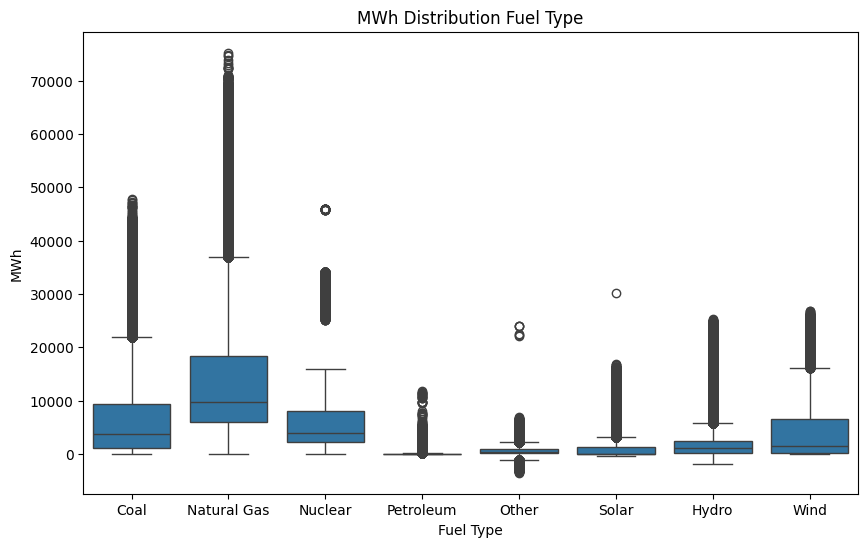

In [27]:
## Plot MWh Distribution by Fuel Type

fuel_dist_plt = plt.figure(figsize=(10, 6))
sns.boxplot(x='type-name', y='value', data=eia_data, legend=False, showfliers=True)
plt.title('MWh Generation Distribution by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('MWh')
fuel_dist_plt.show()
plt.savefig('../images/MWh_Fuel_type.png')

/var/folders/s9/9q8cs9l92wd15gsnz7n8f0x40000gn/T/ipykernel_57140/4000090234.py:8: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



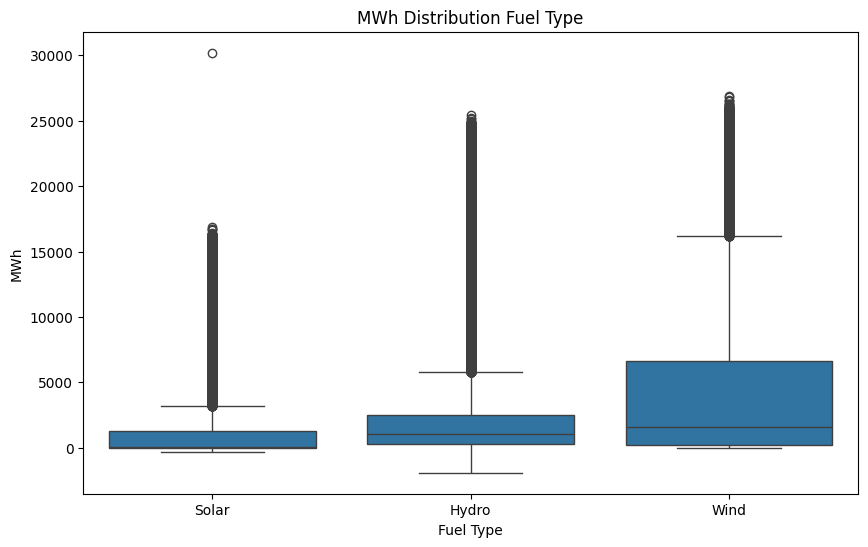

In [71]:
## Mostly curious about Solar, Hydro and Wind
green_data = eia_data[eia_data['type-name'].isin(['Solar', 'Hydro', 'Wind'])].copy()
green_dist_plt = plt.figure(figsize=(10, 6))
sns.boxplot(x='type-name', y='value', data=green_data, legend=False, showfliers=True)
plt.title('MWh Distribution Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('MWh')
green_dist_plt.show()
plt.savefig('../images/MWh_Green_type.png')

In [73]:
# green_data.set_index('date_time').groupby(['respondent-name','type-name']).resample('MS')['value'].sum()

respondent-name  type-name  date_time 
California       Hydro      2022-01-01     1308348
                            2022-02-01     1222636
                            2022-03-01     1529939
                            2022-04-01     1686599
                            2022-05-01     1768042
                            2022-06-01     1857666
                            2022-07-01     2057945
                            2022-08-01     1995743
                            2022-09-01     1908484
                            2022-10-01     1095419
                            2022-11-01      964036
                            2022-12-01     1391474
                            2023-01-01     2106776
                            2023-02-01     1697839
                            2023-03-01     2849610
                            2023-04-01     3387470
                            2023-05-01     3733598
                            2023-06-01     3568119
                            2023-07-01     

# EDA for Demand Data

In [47]:
demand = pd.read_feather('demand.feather')
demand['sales'] = pd.to_numeric(demand['sales'])
demand.head()

,period,stateid,stateDescription,sectorid,sectorName,customers,price,revenue,sales,customers-units,price-units,revenue-units,sales-units,eia_region
0,2023-12,CA,California,IND,industrial,146640,17.99,582.45146,3238.52613,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,California
1,2023-12,WA,Washington,TRA,transportation,5,10.08,1.10199,10.93582,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,Northwest
2,2023-12,WA,Washington,RES,residential,3340072,10.98,438.42493,3991.43173,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,Northwest
3,2023-12,WA,Washington,OTH,other,None,None,None,NaN,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,Northwest
4,2023-12,WA,Washington,IND,industrial,27971,6.1,104.54644,1712.55479,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,Northwest


In [46]:
demand.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 7343 entries, 0 to 2342
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   period            7343 non-null   object
 1   stateid           7343 non-null   object
 2   stateDescription  7343 non-null   object
 3   sectorid          7343 non-null   object
 4   sectorName        7343 non-null   object
 5   customers         6119 non-null   object
 6   price             6119 non-null   object
 7   revenue           6119 non-null   object
 8   sales             6119 non-null   object
 9   customers-units   7343 non-null   object
 10  price-units       7343 non-null   object
 11  revenue-units     7343 non-null   object
 12  sales-units       7343 non-null   object
 13  eia_region        7067 non-null   object
dtypes: object(14)
memory usage: 860.5+ KB


In [42]:
demand.sectorName.unique()

array(['industrial', 'transportation', 'residential', 'other',
       'commercial', 'all sectors'], dtype=object)

In [43]:
demand[demand['sectorName'] == 'all sectors'].head()

,period,stateid,stateDescription,sectorid,sectorName,customers,price,revenue,sales,customers-units,price-units,revenue-units,sales-units,eia_region
6,2023-12,WA,Washington,ALL,all sectors,3770423,9.65,808.63812,8375.63997,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,Northwest
12,2023-12,VA,Virginia,ALL,all sectors,4081231,10.4,1208.82797,11626.37358,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,Mid-Atlantic
18,2023-12,VT,Vermont,ALL,all sectors,385727,18.17,87.06896,479.14123,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,New England
24,2023-12,UT,Utah,ALL,all sectors,1412277,8.53,238.77143,2798.57326,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,Southwest
30,2023-12,TX,Texas,ALL,all sectors,14180392,9.37,3412.78883,36417.69871,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,Texas


/var/folders/s9/9q8cs9l92wd15gsnz7n8f0x40000gn/T/ipykernel_57140/3793173528.py:10: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



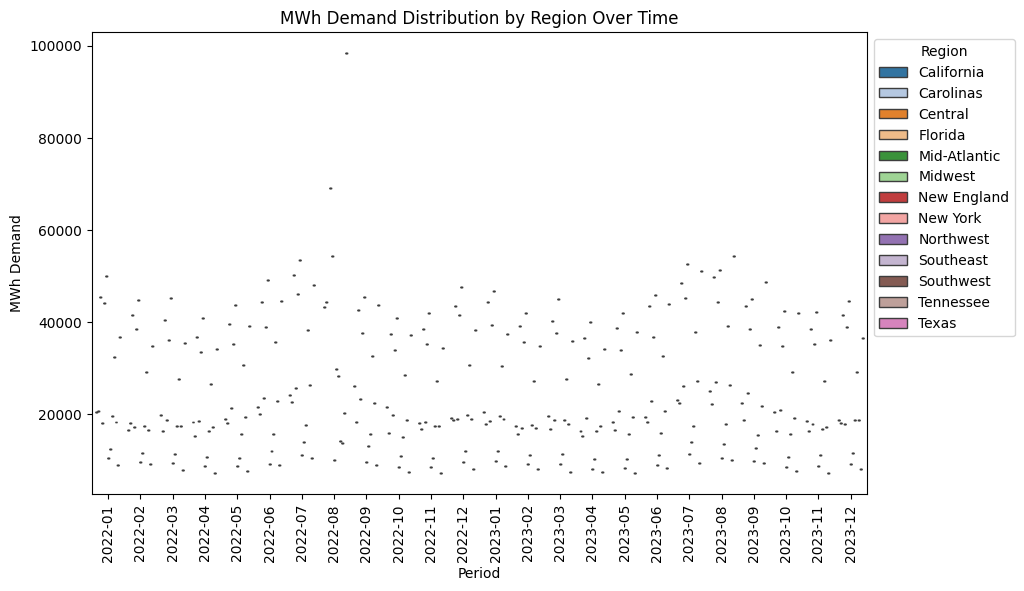

In [61]:
all_demand = demand[demand['sectorName'] == 'all sectors'].copy()
all_demand['period'] = pd.to_datetime(all_demand['period'], format='%Y-%m').dt.strftime('%Y-%m')
all_demand_plt = plt.figure(figsize=(10, 6))
sns.boxplot(x='period', y='sales', data=all_demand.groupby(['period','eia_region']).sales.sum().reset_index(), palette='tab20', hue='eia_region')
plt.title('MWh Demand Distribution by Region Over Time')
plt.xlabel('Period')
plt.ylabel('MWh Demand')
plt.xticks(rotation=90)
plt.legend(title='Region',bbox_to_anchor=(1.2, 1), loc='upper right')
all_demand_plt.show()
plt.savefig('../images/MWh_demand.png')

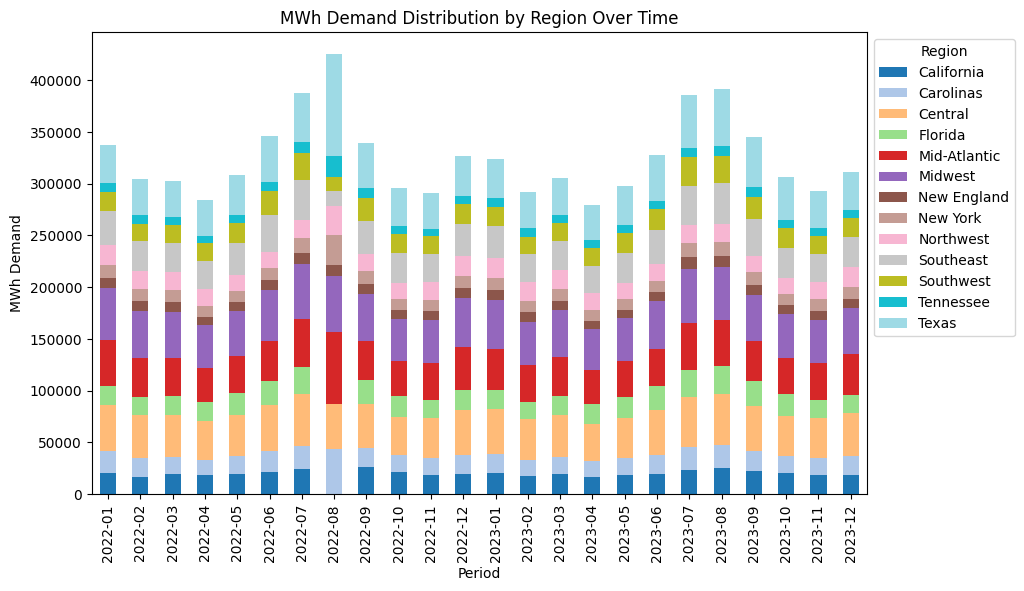

In [62]:
# Grouping and pivoting the data
grouped_data = all_demand.groupby(['period', 'eia_region']).sales.sum().unstack().fillna(0)

# Plotting the stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))
grouped_data.plot(kind='bar', stacked=True, ax=ax, colormap='tab20')

# Customizing the plot
plt.title('MWh Demand Distribution by Region Over Time')
plt.xlabel('Period')
plt.ylabel('MWh Demand')
plt.xticks(rotation=90)
plt.legend(title='Region',bbox_to_anchor=(1.2, 1), loc='upper right')

# Display the plot
plt.show()

# Save the plot
fig.savefig('../images/MWh_demand2.png')